For a 30-step window, a CNN-GRU hybrid is excellent. The CNN extracts spatial patterns (spikes in HR), and the GRU (Gated Recurrent Unit) tracks how those patterns evolve over time. It is faster and more "mobile-friendly" than a standard LSTM.

In [8]:
# ==========================================
# 0. IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.mobile_optimizer import optimize_for_mobile
import os

In [9]:
# ==========================================
# 1. SETTINGS & FEATURES
# ==========================================
# Update these paths to match your local folders
TRAIN_PATH = 'data/train-wearable.csv' 
TEST_PATH = 'data/test-wearable.csv'
MODEL_EXPORT_PATH = 'models/wearable/stress_model.pt'

WINDOW_SIZE = 30
BATCH_SIZE = 64
EPOCHS = 60 # Increased epochs to allow class weights to take effect
LEARNING_RATE = 1e-3

# The "Big 5" real-time features
FEATURES = ['HR', 'MEAN_RR', 'SDRR', 'RMSSD', 'pNN50']
INPUT_DIM = len(FEATURES)
LABEL_MAP = {'no stress': 0, 'interruption': 1, 'time pressure': 2}

In [10]:
# ==========================================
# 2. DATA PREPARATION
# ==========================================
class StressDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

def create_windows(df, scaler=None, is_train=True):
    # Map labels
    df['label'] = df['condition'].map(LABEL_MAP)
    
    # Scale features
    if is_train:
        scaler = StandardScaler()
        df[FEATURES] = scaler.fit_transform(df[FEATURES])
    else:
        df[FEATURES] = scaler.transform(df[FEATURES])

    data = df[FEATURES].values
    labels = df['label'].values

    X_list, y_list = [], []
    for i in range(len(df) - WINDOW_SIZE):
        X_list.append(data[i : i + WINDOW_SIZE])
        y_list.append(labels[i + WINDOW_SIZE - 1])
    
    return np.array(X_list), np.array(y_list), scaler

print(">>> Processing Data...")
df_train_full = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

X_train_all, y_train_all, fitted_scaler = create_windows(df_train_full, is_train=True)
X_test, y_test, _ = create_windows(df_test, scaler=fitted_scaler, is_train=False)

# Validation split
split = int(0.8 * len(X_train_all))
train_loader = DataLoader(StressDataset(X_train_all[:split], y_train_all[:split]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(StressDataset(X_train_all[split:], y_train_all[split:]), batch_size=BATCH_SIZE)
test_loader = DataLoader(StressDataset(X_test, y_test), batch_size=BATCH_SIZE)

# Calculate Class Weights to force model to learn "Time Pressure"
# This fixes the "Everything is No Stress" bug
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_all), 
    y=y_train_all
)
class_weights = torch.tensor(weights, dtype=torch.float)
print(f"Calculated Class Weights: {weights}")

>>> Processing Data...
Calculated Class Weights: [0.61523172 1.17067874 1.92163261]


In [11]:
# ==========================================
# 3. CNN-GRU HYBRID MODEL
# ==========================================
class StressModel(nn.Module):
    def __init__(self, input_dim):
        super(StressModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.gru = nn.GRU(64, 32, num_layers=2, batch_first=True, dropout=0.2)
        self.classifier = nn.Sequential(
            nn.Linear(32, 16), 
            nn.ReLU(), 
            nn.Linear(16, 3)
        )

    def forward(self, x):
        # x: [Batch, Window, Feat] -> transpose for Conv1d
        x = x.transpose(1, 2) 
        x = self.conv(x)
        x = x.transpose(1, 2) 
        _, h_n = self.gru(x)
        return self.classifier(h_n[-1])

In [12]:
# ==========================================
# 4. TRAINING
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StressModel(INPUT_DIM).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# Pass class weights to the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

history = {'train_loss': [], 'val_f1': []}

print(f">>> Training on {device}...")
for epoch in range(EPOCHS):
    model.train()
    t_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
    
    # Validation
    model.eval()
    vp, vt = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb.to(device))
            vp.extend(out.argmax(1).cpu().numpy())
            vt.extend(yb.numpy())
    
    report = classification_report(vt, vp, output_dict=True, zero_division=0)
    f1 = report['macro avg']['f1-score']
    history['train_loss'].append(t_loss/len(train_loader))
    history['val_f1'].append(f1)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {t_loss/len(train_loader):.4f} | Val F1: {f1:.4f}")

>>> Training on cuda...
Epoch 05 | Loss: 0.2768 | Val F1: 0.9045
Epoch 10 | Loss: 0.1974 | Val F1: 0.9295
Epoch 15 | Loss: 0.1661 | Val F1: 0.9375
Epoch 20 | Loss: 0.1483 | Val F1: 0.9492
Epoch 25 | Loss: 0.1384 | Val F1: 0.9576
Epoch 30 | Loss: 0.1302 | Val F1: 0.9589
Epoch 35 | Loss: 0.1262 | Val F1: 0.9625
Epoch 40 | Loss: 0.1200 | Val F1: 0.9677
Epoch 45 | Loss: 0.1163 | Val F1: 0.9675
Epoch 50 | Loss: 0.1133 | Val F1: 0.9622
Epoch 55 | Loss: 0.1118 | Val F1: 0.9637
Epoch 60 | Loss: 0.1096 | Val F1: 0.9708



>>> Running Final Test on test.csv...


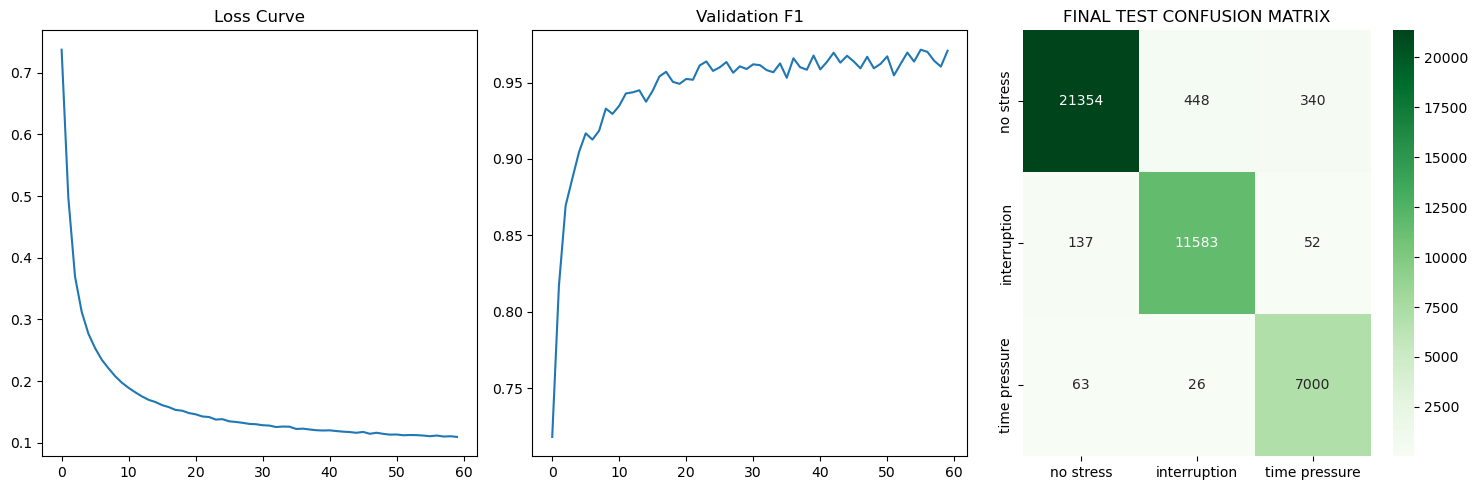


--- FINAL TEST REPORT ---
               precision    recall  f1-score   support

    no stress       0.99      0.96      0.98     22142
 interruption       0.96      0.98      0.97     11772
time pressure       0.95      0.99      0.97      7089

     accuracy                           0.97     41003
    macro avg       0.97      0.98      0.97     41003
 weighted avg       0.97      0.97      0.97     41003



In [13]:
# ==========================================
# 5. FINAL TEST EVALUATION
# ==========================================
print("\n>>> Running Final Test on test.csv...")
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        test_preds.extend(out.argmax(1).cpu().numpy())
        test_targets.extend(yb.numpy())

# Results Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.plot(history['train_loss']); plt.title("Loss Curve")
plt.subplot(1, 3, 2); plt.plot(history['val_f1']); plt.title("Validation F1")
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.title("FINAL TEST CONFUSION MATRIX")
plt.tight_layout()
plt.show()

print("\n--- FINAL TEST REPORT ---")
print(classification_report(test_targets, test_preds, target_names=LABEL_MAP.keys()))

In [14]:
# ==========================================
# 6. WEARABLE EXPORT
# ==========================================
model.eval().to('cpu')
scripted_model = torch.jit.script(model)
optimized_model = optimize_for_mobile(scripted_model)
optimized_model._save_for_lite_interpreter(MODEL_EXPORT_PATH)
print(f"\n>>> Export Successful! {MODEL_EXPORT_PATH} ready.")


>>> Export Successful! models/wearable/stress_model.pt ready.
